In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# main constants

# reference distance (meters)
d0 = 1 
# constant for particular propagation enviroment
k = 1e-4
# path loss exponent
n = 4
# total available bandwidth (Hz)
b_t = 100 * 1e6
# constant for noise power (W/Hz)
k_0 = 1e-20
# Side of total area (meters)
area_side = 1e3

In [3]:
def lin2db(x):
    return 10.0*np.log10(x)

def db2lin(x):
    return 10.0**(x/10.0)

def lin2dbm(x):
    return 10.0*np.log10(x)+30.0

def dbm2lin(x):
    return 10.0**(x/10.0 - 3.0)

In [4]:
def random_position():
    
    x_position = np.random.rand()*area_side
    y_position = np.random.rand()*area_side
    
    return [x_position, y_position]

def distance(UE_position, AP_position):

    distance_calculated =  np.linalg.norm(np.array(UE_position)
                                          - np.array(AP_position))

    return distance_calculated
    
def AP_position(AP_quantity):
    
    # Generates a list of coordenates according to the number of APs
    # in the simulation. It distributes the APs evenly.

    # Checks if the number of APs is a perfect square.
    if np.sqrt(AP_quantity).is_integer(): 

        AP_quantity_side = int(np.sqrt(AP_quantity))
    
        cell_side = area_side // AP_quantity_side
    
        # Creates coordenates using meshgrid.
        x, y = np.meshgrid(np.arange(0.5 * cell_side, 
                                     area_side, 
                                     cell_side),
                           np.arange(0.5 * cell_side, 
                                     area_side, 
                                     cell_side))
        
        APs_positions = np.column_stack((x.ravel(), y.ravel()))
    else:
        print("AP quantity must be a perfect square")

    return APs_positions

In [5]:
# Functions to calculate equations given by the base material

def calculate_received_power(transmitted_power, shadowing, distance):
    return transmitted_power * shadowing * (k / (distance**n))
    
def calculate_bandwidth_channel(total_bandwidth, channels_quantity):
    return total_bandwidth / channels_quantity

def calculate_noise_power(total_bandwidth, channels_quantity):
    return k_0 * calculate_bandwidth_channel(total_bandwidth, channels_quantity)

def calculate_SNR(user_power, noise_power):
    return user_power / noise_power

def calculate_SINR(user_power, interference_power, noise_power):
    return user_power / (interference_power + noise_power)

In [6]:
def eCDF(data):
    x = np.sort(data)
    y = np.arange(0, len(data)) / len(data)

    return x, y  

In [7]:
# Models the UEs
class UserEquipment:
    
    def __init__(self, transmitted_power_ = 0.25): # UE transmission power is 1 W by standard
        
        # Distance is sorted randomly in a 1000x1000m area 
        self.position = random_position()
        self.distance2AP = 0
        
        self.transmitted_power = 0.25
        self.received_power = 0

In [8]:
# Models the APs
class AccessPoint:

    def __init__(self, channels_quantity_, position_ = [0, 0]):

        self.position = position_

        # Adds keys with a empty list for each channel in the system
        self.channels = dict()
        for m in range(channels_quantity_):
            self.channels[m + 1] = []

In [9]:
# CLass that plots the APs and UEs
class LinkSystem:

    '''
    for fractional power control, power_control = 0
    for max rate, power_control = 1
    '''
    def __init__(self, AP_quantity_, 
                       UE_quantity_, 
                       channels_quantity_,
                       power_control,
                       max_power_ = 0.25):

        self.AP_quantity = AP_quantity_
        self.AP_list = []
        
        self.UE_quantity = UE_quantity_
        self.UE_list = []
        
        self.channels_quantity = channels_quantity_

        self.noise_power = calculate_noise_power(b_t, 
                                                 self.channels_quantity)

        self.max_power = max_power_
        
        ''' Matrix of shadowing of each link, in which the rows are related to UEs
        and columns are related to APs '''
        self.shadowing_matrix = np.zeros((self.UE_quantity, 
                                          self.AP_quantity))

        # The shadowing is a zero-mean lognormal distributed random variable with
        # standard deviation 2.0
        for UE in range(self.UE_quantity):
            for AP in range(self.AP_quantity):
                self.shadowing_matrix[UE][AP] = np.random.lognormal(sigma=2.0)  

        
        ''' Add APs in system '''

        # Generates the APs positions according to the AP quantity
        # in order to have evenly distributed positions
        positions = AP_position(self.AP_quantity)
        index = 0
        
        for AP in range(self.AP_quantity):
            
            self.AP_list.append(AccessPoint(self.channels_quantity, 
                                            positions[index]))
            index += 1


        ''' add UEs to the system '''
        for UE in range(self.UE_quantity):
                self.UE_list.append(UserEquipment())  

        
        ''' Matrix of shadowing of each link, in which the rows are related to UEs
        and columns are related to APs '''
        self.gain_matrix = np.zeros((self.UE_quantity,
                                     self.AP_quantity))
        
        # The gain is calculated as the product between the shadowing and the path loss      
        for UE in range(self.UE_quantity):
            for AP in range(self.AP_quantity):
                gain = ((self.shadowing_matrix[UE][AP] * k) 
                         / distance(self.UE_list[UE].position, self.AP_list[AP].position)**n)
                
                self.gain_matrix[UE][AP] = gain
                
        ''' 
        Makes the power control
        
        Fractional Power Control: Sets the power as the minimum value between the maximum power and the formula given
        by the article.

        Max Power: All users transmit with the maximum power.
        '''
        if power_control == 0:

            max_power = self.max_power # Maximum achievable power in watts
            compensation_factor = 0.8 # Compensation factor as given by article (debatable)
            target_received_power = dbm2lin(-20) # P_0 = -35 dBm
           
            self.power_list = []
       
            for i in range(self.UE_quantity):

                # zeta as defined in article (how to cite?)
                zeta = np.sqrt(sum(self.gain_matrix[i]))
                new_transmitted_power = (target_received_power 
                                         * pow(zeta, - compensation_factor)) 
                
                if new_transmitted_power < self.max_power:
                    self.power_list.append(new_transmitted_power)
                else:
                    self.power_list.append(max_power)
        
            for power in range(self.UE_quantity):
                    
                self.UE_list[power].transmitted_power = self.power_list[power]
                    
        elif power_control == 1:

            for power in range(self.UE_quantity):

                self.UE_list[power].transmitted_power = self.max_power

        
        ''' Stores the linked AP from each UE according to channel
        and allocate them in this AP channels '''
        for UE in range(self.UE_quantity):

            linkedAP = 0
            min_gain = float('-inf')
            
            for AP in range(self.AP_quantity):
                if self.gain_matrix[UE][AP] > min_gain:
                    linkedAP = self.AP_list[AP]
                    min_gain = self.gain_matrix[UE][AP]
                
            
            ''' Uses the AP with better channel, that it stored in the loop above.
            Stores the better channel AP from each UE and allocate them in 
            this AP channels, calculating its distance to linked AP. '''

            if self.channels_quantity > 1:
                linkedAP.channels[np.random.randint(1, self.channels_quantity)].append(self.UE_list[UE])
            else:
                linkedAP.channels[1].append(self.UE_list[UE])

            if distance(self.UE_list[UE].position, 
                        linkedAP.position) > d0:
                self.UE_list[UE].distance2AP = distance(self.UE_list[UE].position, 
                                                        linkedAP.position)
            else:
                self.UE_list[UE].distance2AP = d0


        
        
        self.SNR_list = []
        self.SINR_list = []
        self.capacity_list = []
            
        ''' It calculates each UE KPI for each AP channel '''
        for AP in self.AP_list:
                                
            for channel in AP.channels:
                
                # Power sum of all UEs in the channel
                power_sum = 0
                
                # Calculates the received power of each UE
                for UE in AP.channels[channel]:           

                    # Calculates the received power of each UE
                    UE.received_power = calculate_received_power(UE.transmitted_power, 
                                                                 self.shadowing_matrix[self.UE_list.index(UE)][self.AP_list.index(AP)],
                                                                 UE.distance2AP)
                    
                    power_sum += UE.received_power
                        
                for UE in AP.channels[channel]:
    
                    # Calculating SNR
                    self.SNR_list.append(lin2db(calculate_SNR(UE.received_power, 
                                                              self.noise_power)))
    
                    # Calculating SINR
                    UE.interfering_power = power_sum - UE.received_power
                    
                    self.SINR_list.append(lin2db(calculate_SINR(UE.received_power,
                                                                UE.interfering_power,
                                                                self.noise_power)))
                
                # Calculating Spectral Efficiency
                for user_SINR_ in range(len(self.SINR_list)):
                    bandwidth_ = calculate_bandwidth_channel(b_t, self.channels_quantity)
                    self.capacity_list.append(bandwidth_ * np.log2(1 + db2lin(self.SINR_list[user_SINR_])) / 1e6)
    
    def stepwise_removal_algorithm(self):

        ''' First step '''
        
        ''' Matrix F as defined in Han Liu '''

        # F is a square matrix made by a gain array K times, which K is the gain matrix 
        # dimension and each term is defined by Han Liu.
        linear_gain_matrix = np.ndarray.flatten(self.gain_matrix) 
        K = len(linear_gain_matrix)
        
        gain_aux_matrix = np.zeros((K, K))
        matrix_F = np.zeros((K, K))

        # Gain matrix 
        for row in range(K):
            gain_aux_matrix[row] = linear_gain_matrix

        # Condition for i != j
        for row in range(K):
            matrix_F[row] = gain_aux_matrix[row] / gain_aux_matrix[row][row]

        # Condition for i = j
        matrix_F[np.where(matrix_F==1)] = 0

        
        ''' The maximal achievable SINR'''        

        # The maximal achievable SINR is the inverse of the maximal eigenvalue of F.
        
        eigenvalues_matrix = np.linalg.eig(matrix_F)[0]
        
        maximal_achievable_SINR = 1 / eigenvalues_matrix.max()

        
        ''' Matrix D as defined in Han Liu '''

        # D is a diagonal matrix which the main diagonal is the target SINR for each user.
        # Here the target SINR is constant for all users
        
        target_SINR = dbm2lin(-20) 
        target_SINR_array = np.zeros(K)
        
        target_SINR_array[np.where(target_SINR_array==0)] = target_SINR
        matrix_D = np.diag(target_SINR_array)

        ''' Matrix u as defined in Han Liu '''

        # u is a square matrix that relates the target SINR, the thermal noise and the channel gain
        
        matrix_u = np.zeros(K)
        thermal_noise = self.noise_power

        for j in range(K):    
            matrix_u[j] = ( target_SINR_array[j] * thermal_noise ) / gain_aux_matrix[j][j] 

        ''' Defines P if the condition is satisfied according to Han Liu '''

        while True:
        
            # P is the optimal power array for the system
            if maximal_achievable_SINR >= target_SINR:
                P = np.linalg.inv(np.identity(K) - matrix_D * matrix_F) * matrix_u
                break
                    
            else:
    
                max_value = float('-inf')
                max_j = 0
                
                for j in range(K):
                    soma = sum(np.transpose(matrix_F)[j])
    
                    if soma > max_value:
                        max_value = soma
                        max_j = j
    
                matrix_F = np.delete(matrix_F, j, 0)
                matrix_F = np.delete(matrix_F, j, 1)

        print(matrix_F)
        print(P)

In [10]:
# Simulation parameters

iteracoes = 1 # The quantity of simulations
users_quantity = 10
AP_quantity = 16
channels_quantity = 1

In [11]:
total_SNR = []
total_SINR = []
total_capacity = []


for inter in range(iteracoes):
    
    # Creates many Users at once
    system = LinkSystem(AP_quantity, 
                        users_quantity, 
                        channels_quantity,
                        1)

    system.stepwise_removal_algorithm()
    
    # The SNR, SINR and spectral efficiency of users    
    total_SNR = np.concatenate((total_SNR, 
                                system.SNR_list))
    
    total_SINR = np.concatenate((total_SINR, 
                                 system.SINR_list))
    
    total_capacity = np.concatenate((total_capacity, 
                                     system.capacity_list))

[[0.00000000e+00 6.07064362e-02 9.84029672e-01 ... 5.59829699e-03
  2.15829799e-01 4.69087862e-02]
 [1.64727179e+01 0.00000000e+00 1.62096432e+01 ... 9.22191672e-02
  3.55530340e+00 7.72715204e-01]
 [1.01622952e+00 6.16916724e-02 0.00000000e+00 ... 5.68915466e-03
  2.19332613e-01 4.76700932e-02]
 ...
 [1.78625750e+02 1.08437327e+01 1.75773038e+02 ... 0.00000000e+00
  3.85527598e+01 8.37911713e+00]
 [4.63328050e+00 2.81269947e-01 4.55928549e+00 ... 2.59384803e-02
  0.00000000e+00 2.17341565e-01]
 [2.13179679e+01 1.29413786e+00 2.09775130e+01 ... 1.19344316e-01
  4.60105273e+00 0.00000000e+00]]
[[0.00124418 0.         0.         ... 0.         0.         0.        ]
 [0.         0.02049507 0.         ... 0.         0.         0.        ]
 [0.         0.         0.00126438 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.22224306 0.         0.        ]
 [0.         0.         0.         ... 0.         0.00576465 0.        ]
 [0.         0.         0.    

In [12]:
total_SNR_ = []
total_SINR_ = []
total_capacity_ = []


for inter in range(iteracoes):
    
    # Creates many Users at once
    system_ = LinkSystem(AP_quantity, 
                         users_quantity, 
                         channels_quantity,
                         0)
    
    # The SNR, SINR and spectral efficiency of users    
    total_SNR_ = np.concatenate((total_SNR_, 
                                system_.SNR_list))
    
    total_SINR_ = np.concatenate((total_SINR_, 
                                 system_.SINR_list))
    
    total_capacity_ = np.concatenate((total_capacity_, 
                                      system_.capacity_list))

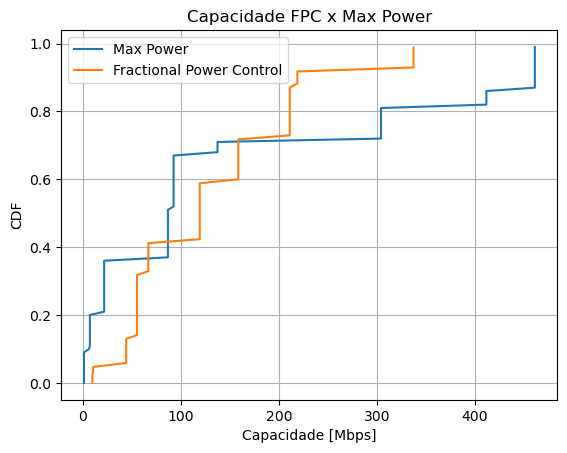

In [13]:
capacityCDF = eCDF(total_capacity)
SINR_CDF = eCDF(total_SINR)
SNR_CDF = eCDF(total_SNR)

capacityCDF_ = eCDF(total_capacity_)
SINR_CDF_ = eCDF(total_SINR_)
SNR_CDF_ = eCDF(total_SNR_)

plt.title('Capacidade FPC x Max Power')
plt.xlabel('Capacidade [Mbps]')
plt.ylabel('CDF')

# plt.ylim(0.0, 1.0)
# plt.xlim(-1, 750)
plt.plot(capacityCDF[0], capacityCDF[1], label = 'Max Power')
plt.plot(capacityCDF_[0], capacityCDF_[1], label = 'Fractional Power Control')
plt.legend()
plt.grid()

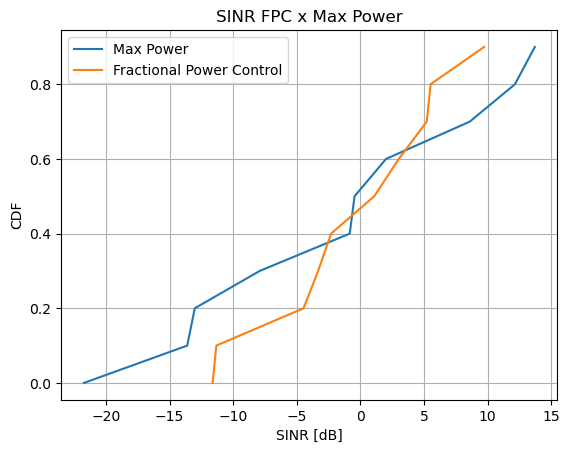

In [14]:
plt.title('SINR FPC x Max Power')
plt.xlabel('SINR [dB]')
plt.ylabel('CDF')

# plt.ylim(0.0, 1.0)
# plt.xlim(-1, 750)
plt.plot(SINR_CDF[0], SINR_CDF[1], label = 'Max Power')
plt.plot(SINR_CDF_[0], SINR_CDF_[1], label = 'Fractional Power Control')
plt.legend()
plt.grid()

In [15]:
# spectral_efficiencyCDF = eCDF(b_t*total_spectral_efficiency)
# SINR_CDF = eCDF(total_SINR)
# SNR_CDF = eCDF(total_SNR)

# spectral_efficiencyCDF_ = eCDF(b_t*total_spectral_efficiency_)
# SINR_CDF_ = eCDF(total_SINR_)
# SNR_CDF_ = eCDF(total_SNR_)

# plt.title('Capacidade FPC x Max power')
# plt.xlabel('Capacidade de canal [Mbps]')
# plt.ylabel('CDF')

# # plt.ylim(0.0, 1.0)
# plt.xlim(-10,500)
# plt.plot(spectral_efficiencyCDF[0]/1e6, spectral_efficiencyCDF[1], label = 'Max Power')
# plt.plot(spectral_efficiencyCDF_[0]/1e6, spectral_efficiencyCDF_[1], label = 'Fractional Power Control')
# plt.legend()
# plt.grid()